In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

import torch

from pipeline.interface import get_model

In [2]:
def construct_input_prompt(user_prompt):
    SYSTEM_MESSAGE = "The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.\n"
    IMAGE_TOKEN = "Human: <image>\n" #<image> denotes an image placeholder.
    USER_PROMPT = f"Human: {user_prompt}\n"

    return SYSTEM_MESSAGE + IMAGE_TOKEN + USER_PROMPT + "AI: "

In [3]:
# Load trained model
ckpt_path = "checkpoints/7B-C-Abs-M256/last/"
model, tokenizer, processor = get_model(ckpt_path, use_bf16=True)
model.cuda()
print("Model initialization is done.")

You are using a model of type mllm to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


INFO 04/30 00:21:08 | Build vision model ...
INFO 04/30 00:21:09 | Build projector ...
INFO 04/30 00:21:10 | Build LM ...


You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuratio

Model initialization is done.


In [4]:
prompts = [construct_input_prompt("Explain why this meme is funny.")]
image_list = ["./examples/monday.jpg"]

In [5]:
images = [Image.open(_) for _ in image_list]
inputs = processor(texts=prompts, images=images)
inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
inputs = {k: v.to(model.device) for k, v in inputs.items()}

In [6]:
# generate kwargs (the same in transformers) can be passed in the do_generate()
generate_kwargs = {
    'do_sample': True,
    'top_k': 5,
    'max_length': 512
}

In [7]:
with torch.no_grad():
    res = model.generate(**inputs, **generate_kwargs)
sentence = tokenizer.batch_decode(res, skip_special_tokens=True)

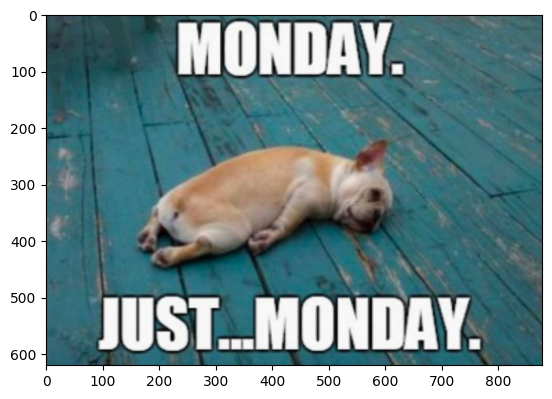

generated: This meme is funny because it features a small dog lying on the floor, possibly a French bulldog, which is a popular and cute breed. The dog appears to be sleeping or resting, and the caption "Monday. Just...Monday" adds a humorous twist to the image. The combination of the dog's relaxed state and the reference to a typical Monday morning creates a lighthearted and amusing visual. It can be seen as a playful way to express the idea that Mondays can be tough or challenging, but it's also possible to find comfort and humor in everyday situations.


In [8]:
# Show the inference result.
plt.imshow(images[0])
plt.show()
print(f"generated: {sentence[0]}")